# Segmentation Practical

In this notebook, we will learn how to identify objects based on their color and extract the center and area of these objects.  

Throughout this notebook, complete **Exercises** and **`TODO` sections** in code blocks.

## Table of Contents
1. [Getting Started](#GettingStarted)
1. [Loading Photos](#LoadingPhotos)
1. [Color Formats](#ColorFormats)
1. [Masks](#Masks)
1. [Finding Contours](#FindingContours)
1. [Contour Center](#ContourCenter)
1. [Contour Area](#ContourArea)

<a id="GettingStarted"></a>
## 1. Getting Started

First, we will import the necessary libraries for this notebook, including Python libraries (`cv`, `numpy`, etc.) and helpers.

In [1]:
# Import Python libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import glob

The following functions will help us throughout this notebook.

In [2]:
# Charlie Lai

def draw_contour(image, contour, color=(0, 255, 0)):
    """
    Draws a contour on the provided image.

    Args:
        image: The image on which to draw the contour.
        contour: The contour to draw on the image.
        color: The color to draw the contour in BGR format.
    """
    cv2.drawContours(image, [contour], 0, color, 3)

    
def draw_circle(color_image, center, color=(0, 255, 255), radius=6):
    """
    Draws a circle on the provided image.

    Args:
        color_image: The color image on which to draw the contour.
        center: The pixel (row, column) of the center of the image.
        color: The color to draw the circle in BGR format.
        radius: The radius of the circle in pixels.
    """
    # cv.circle expects the center in (column, row) format
    cv2.circle(color_image, (center[1], center[0]), radius, color, -1)

    
def show_color_rgb(red, green, blue):
    """
    Displays a color specified in the RGB format.
    """
    rectangle = plt.Rectangle((0,0), 50, 50, fc=(red/255, green/255, blue/255))
    plt.gca().add_patch(rectangle)
    plt.show()

    
def show_color_hsv(hue, saturation, value):
    """
    Displays a color specified in the HSV format
    """
    # Convert from hsv to rgb
    hsv = np.array([[[hue, saturation, value]]], np.uint8)
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    
    show_color_rgb(rgb[0][0][0], rgb[0][0][1], rgb[0][0][2])

<a id="LoadingPhotos"></a>
## 2. Loading Photos
Here we will load a photo of a blank stop sign.

In [4]:
# Load a stop sign image
sign_file = "stopsigns/blank_stop_sign.jpg"
stopsign = cv2.imread(sign_file, cv2.IMREAD_COLOR)

## Question
We have opened the image using OpenCV. What color format is the images in? BGR or RGB? If you need a hint, run the next cell...

docs.opencv.org/3.4.1/d3/df2/tutorial_py_basic_ops.html

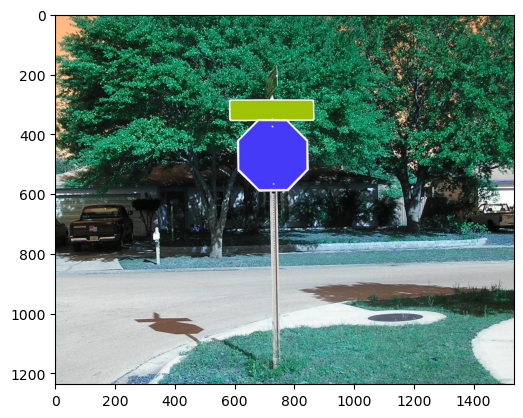

In [5]:
# Show the stop sign
plt.imshow(stopsign);

## Exercise 1

Convert the stop sign image from BGR to RGB (cv2.cvtColor(YOUR_IMAGE, cv2.COLOR_BGR2RGB)) and to HSV. 

For each colorspace, visualize the three channels by displaying the image.

Which colorspace isolates the stop sign the best?

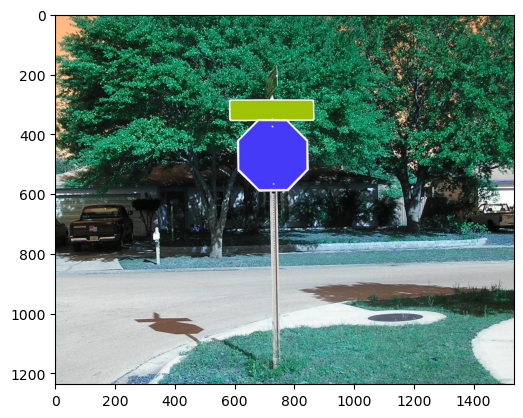

In [6]:
# First, put the stop sign into a variable
sign_img = stopsign

# And display it in it's native format
plt.imshow(sign_img);

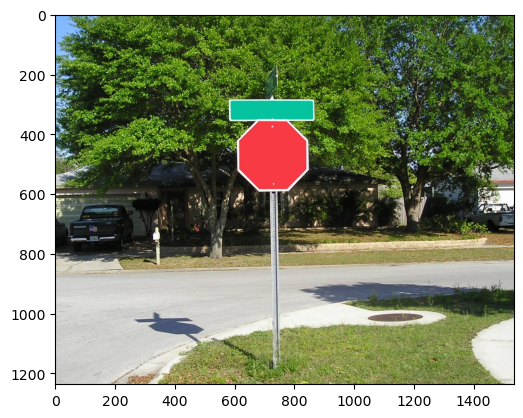

In [9]:
# Now convert and display it in RGB format
rgb_img =  cv2.cvtColor(sign_img, cv2.COLOR_BGR2RGB)# TODO: Your code here to convert sign_img to RGB
plt.imshow(rgb_img);

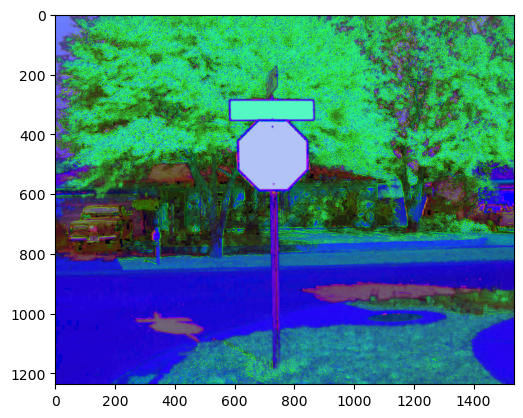

In [10]:
# And convert and display it in HSV format
hsv_img =  cv2.cvtColor(sign_img, cv2.COLOR_BGR2HSV)# TODO: Your code here to convert to HSV
plt.imshow(hsv_img);

Color images are stored as three dimensional numpy arrays:

* **0th dimension**: pixel rows, indexed from top to bottom.
* **1st dimension**: pixel columns, indexed from left to right.
* **2nd dimension**: pixel color values, ordered red, green, blue, each ranging from 0 (none of that color) to 255 (maximum amount of that color).

Let's look at the color values of the middle pixel of our image.

(1237, 1535, 3)
rows: 1237
columns: 1535
red: 70
green: 72
blue: 59


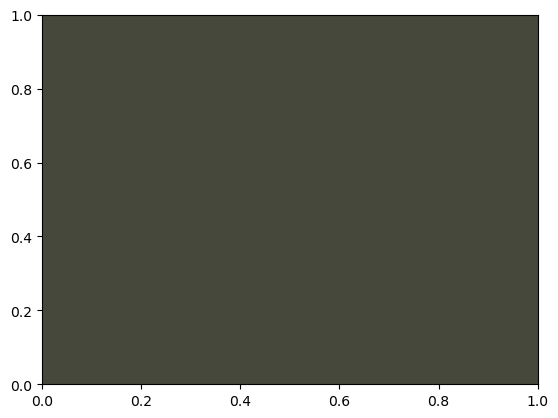

In [11]:
# Display the image dimensions
img_shape = rgb_img.shape
print(img_shape)
print("rows: {}".format(img_shape[0]))
print("columns: {}".format(img_shape[1]))

# Calculate center row and column
row = rgb_img.shape[0] // 2
col = rgb_img.shape[1] // 2

# Extract and print blue, green, and red values
red = rgb_img[row][col][0]
green = rgb_img[row][col][1]
blue = rgb_img[row][col][2]

print("red:", red)
print("green:", green)
print("blue:", blue)

# Display this color
show_color_rgb(red, green, blue)

## Exercise 2
Update `row` and `col` in the following code block to show a pixel that you expect to be strongly blue, green, or red based on the stop sign image you have loaded.

red: 5
green: 195
blue: 161


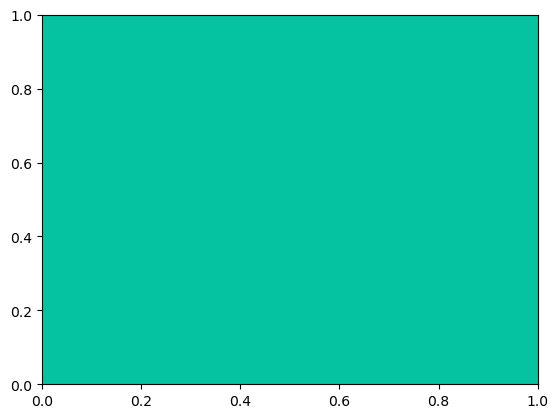

In [19]:
# TODO: Identify the desired row and column 
row = 300
col = 750

# Extract and print red, green, and blue values
red = rgb_img[row][col][0]
green = rgb_img[row][col][1]
blue = rgb_img[row][col][2]

print("red:", red)
print("green:", green)
print("blue:", blue)

# Display this color
show_color_rgb(red, green, blue)

<a id="ColorFormats"></a>
## 3. Color Formats
By default, the images loaded with OpenCV are stored in the blue-green-red (BGR) format, and image plotting in matplotlib assumes the red-green-blue (RGB) format.  However, when recognizing objects based on their color, it is far easier to use yet another format, the hue-saturation-value (HSV) format, in which each channel corresponds to the following:

* **Hue** (0 to 180): The color as it appears on a color wheel, ordered as red-orange-yellow-green-blue-purple-red
* **Saturation** (0 to 255): The amount of white added to the color.  0 is pure white, and 255 is the pure color without any white added.
* **Value** (0 to 255): The amount of black added to the color.  0 is pure black, and 255 is the pure color without any black added.

While saturation and value vary with lighting, hue will remain mostly the same regardless of lighting.  By focusing on the hue of the object we are attempting to detect, we can find it even in different lighting environments.

## Exercise 3

We can use the following widgets to experiment with different color values in the RGB and HSV formats.  

**For both formats, find the values which produce the following colors: orange, red, dark green, and blue.**

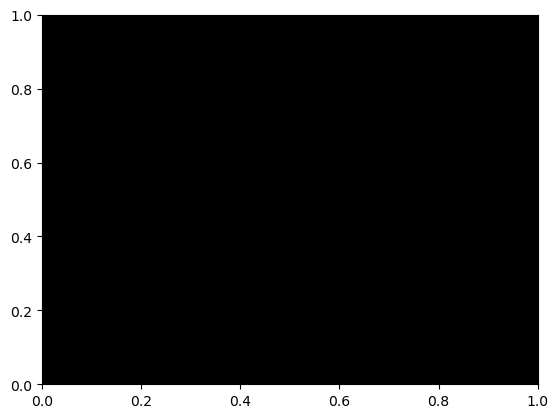

In [38]:
# RGB color
widgets.interact(show_color_rgb,
                 red=widgets.IntSlider(0, 0, 255, continuous_update=False),
                 green=widgets.IntSlider(0, 0, 255, continuous_update=False),
                 blue=widgets.IntSlider(0, 0, 255, continuous_update=False));

# orange = (255, 100, 0)
# red = (100, 0, 0)
# dark green = (0, 100, 0)
# blue = (0, 0, 255)

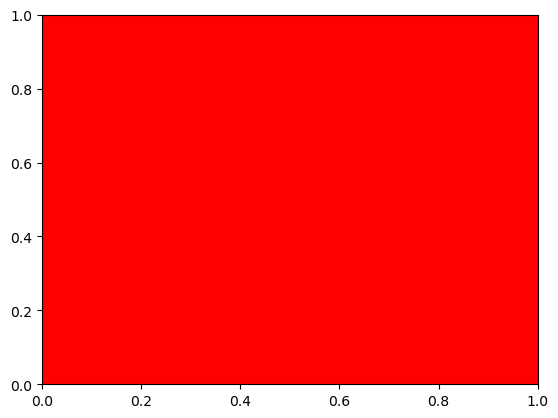

In [37]:
# HSV color
widgets.interact(show_color_hsv,
                 hue=widgets.IntSlider(0, 0, 180, continuous_update=False),
                 saturation=widgets.IntSlider(255, 0, 255, continuous_update=False),
                 value=widgets.IntSlider(255, 0, 255, continuous_update=False));
#orange=(17, 255, 255)
#red=(0, 255, 255)
#dk. green=(64, 255, 115)
#blue=(120, 255, 255)

<a id="Masks"></a>
## 4. Masks
Lets work on identifying an object in the image based on its color.  Specifically, we will isolate the portions of an image which fall within a certain color range by defining **upper** and **lower** HSV bounds.  We will use that to create a *mask* - a special type of image which is white in areas to include and black in areas not to include.


## Exercise 4

**Finish writing the function `get_mask` below, which takes an image and returns a mask of the areas between hsv_lower and hsv_upper.**  You will likely wish to use the following OpenCV functions:

* `cvtColor`(docs.opencv.org/4.2.0/d8/d01/group__imgproc__color__conversions.html#ga397ae87e1288a81d2363b61574eb8cab)
   * Converts an image from one color format to another, such as from RGB to HSV.
* `inRange`(docs.opencv.org/4.2.0/d2/de8/group__core__array.html#ga48af0ab51e36436c5d04340e036ce981)
   * Creates a mask from an image based on a lower and upper color bound.

In [39]:
def get_mask(image, hsv_lower, hsv_upper):
    """   
    Returns a mask containing all of the areas of image which were between hsv_lower and hsv_upper.
    
    Args:
        image: The image (stored in BGR) from which to create a mask.
        hsv_lower: The lower bound of HSV values to include in the mask.
        hsv_upper: The upper bound of HSV values to include in the mask.
    """
    # Convert hsv_lower and hsv_upper to numpy arrays so they can be used by OpenCV
    hsv_lower = np.array(hsv_lower)
    hsv_upper = np.array(hsv_upper)

    # TODO: Use the cv2.cvtColor function to switch our RGB colors to HSV colors
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    # TODO: Use the cv2.inRange function to highlight areas in the correct range
    mask = cv2.inRange(hsv_image, hsv_lower, hsv_upper)
    
    return mask

## Exercise 5
Next, we will use the `get_mask` function to create a mask containing just the stop sign in our `sign_img`.  At the moment, `hsv_lower` and `hsv_upper` include all possible HSV values, so the mask will contain the entire image.  

**Tune the values of `hsv_lower` and `hsv_upper` until the mask only includes the cone(s).**

**Hints:**

* Use the HSV color widget from the **Color Formats** section above to visualize HSV colors.
* Copy the image into an image editing software (gimp, paint, etc.) and use the eyedropper (color picker) tool to show the HSV values of the pixels in the stop sign.
* Saturation and value vary a lot with lighting, but hue will remain mostly constant for a given object. Try using a wide range for value and saturation but a tight range for hue.

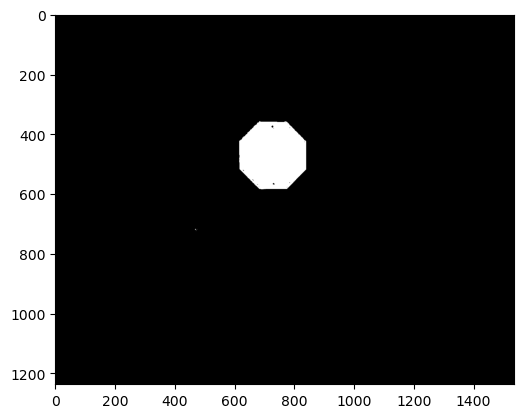

In [49]:
# TODO: change these bounds
hsv_lower = (150, 100, 100)
hsv_upper = (180, 255, 255)

mask = get_mask(rgb_img, hsv_lower, hsv_upper)

plt.imshow(mask, cmap = 'gray');

We can use this mask as a filter for our original image to only keep portions that were between `hsv_lower` and `hsv_upper`.

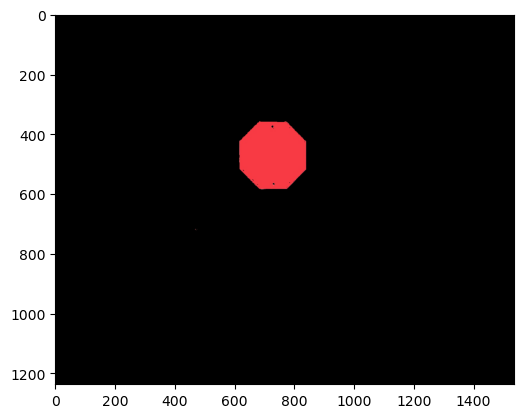

In [50]:
masked_image = cv2.bitwise_and(rgb_img, rgb_img, mask=mask)
plt.imshow(masked_image);

<a id="FindingContours"></a>
## 5. Finding Contours

Now that we have a mask, we can create outlines called _contours_ around each object in the mask.  We will use these outlines to identify the largest object and calculates its size and position.

First, we will use the OpenCV function `findContours`(docs.opencv.org/4.2.0/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0) to create a list of contours around each distinct object in the mask.

In [51]:
def find_contours(mask):
    """
    Returns a list of contours around all objects in a mask.
    """
    return cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]

`find_contours` will return a list containing multiple contours if there are multiple distinct objects which fall between `hsv_lower` and `hsv_upper`.  This might occur if there are multiple stop signs in the image or if there are other objects that have a similar color to the stop sign(s).

## Exercise 6

Let's write a helper function to identify the largest contour, which we will assume is the closest stop sign.  This helper function should also ignore contours below a minimum size (such as `30 pixels`), since anything below this size is likely too small to be recognized.

**Finish writing `get_largest_contour` so that it returns the largest contour larger than `min_area`, or returns `None` if no such contour exists.**  

You will likely wish to use the OpenCV `contourArea` (docs.opencv.org/4.2.0/d3/dc0/group__imgproc__shape.html#ga2c759ed9f497d4a618048a2f56dc97f1) function to find the number of pixels in a contour.

In [70]:
def get_largest_contour(contours, min_area=30):
    """
    Finds the largest contour with size greater than min_area.

    Args:
        contours: A list of contours found in an image.
        min_area: The smallest contour to consider (in number of pixels)

    Returns:
        The largest contour from the list, or None if no contour was larger than min_area.
    """
    if len(contours) == 0:
        # TODO: What should we return if the list of contours is empty?
       return None

    
    # TODO: Return the largest contour, but return None if no contour is larger than min_area
    greatest_area = min_area
    greatest_contour = None
    for contour in contours:
        if cv2.contourArea(contour) > greatest_area:
            greatest_contour = contour
            greatest_area = cv2.contourArea(contour)
    return greatest_contour

Let's try it out.  The following code block uses `find_contours` and `get_largest_contour` to find the largest contour and draw it on the image.  We should now see a green outline surrounding the closest stop sign in our image.

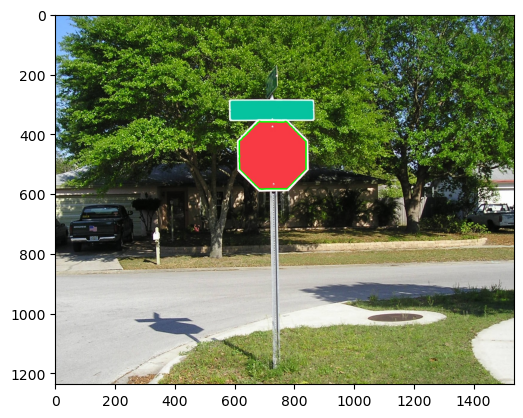

In [71]:
# Find the largest contour
contours = find_contours(mask)
largest_contour = get_largest_contour(contours)

# Draw it on the image
image_copy = np.copy(rgb_img)
draw_contour(image_copy, largest_contour)
plt.imshow(image_copy);

<a id="ContourCenter"></a>
## 6. Contour Center

One advantage of contours is that we can use them to easily calculate the center of an object.  Specifically, we will use the contour's _Moments_ (en.wikipedia.org/wiki/Image_moment), which are weighted averages of the pixels in the contour.  We can calculate the moment $M_{ij}$ with the following formula:

```
def moment(i, j):
    sum = 0
    for pixel in contour:
        sum += pixel.x_position ** i + pixel.y_position ** j
    return sum
```

To calculate contour center, we will use the following moments:

* $M_{00}$: The number of pixels in the contour.
* $M_{10}$: The sum of how far to the right each pixel in the contour is.
* $M_{01}$: The sum of how far down each pixel in the contour is.

Using the center of mass equation (en.wikipedia.org/wiki/Center_of_mass), $\frac{M_{10}}{M_{00}}$ gives us the average horizontal position (column) of the contour, and $\frac{M_{01}}{M_{00}}$ gives us the average vertical position (row).

We can access these moments from OpenCV's moments calculation using M['m00'], M['m01'], and M['m10'].

## Exercise 7

Complete the `get_contour_center` function below to find the contour center. 

**Please calculate the center row and column of the contour using the Moments.**

In [75]:
def get_contour_center(contour):
    """
    Finds the center of a contour from an image.

    Args:
        contour: The contour of which to find the center.

    Returns:
        The (row, column) of the pixel at the center of the contour, or None if the contour is empty.
    """
    # Ask OpenCV to calculate the contour's moments
    M = cv2.moments(contour)

    # Check that the contour is not empty
    if M["m00"] <= 0:
        return None

    # TODO: Compute the center of mass of the contour
    center_row = 0
    center_column = 0
    center_row = int(M["m01"] / M["m00"])
    center_column = int(M["m10"] / M["m00"])
    
    return (center_row, center_column)

To see if this worked, we will draw a dot at this calculated center point. We should now see a yellow dot at the center of the stop sign.

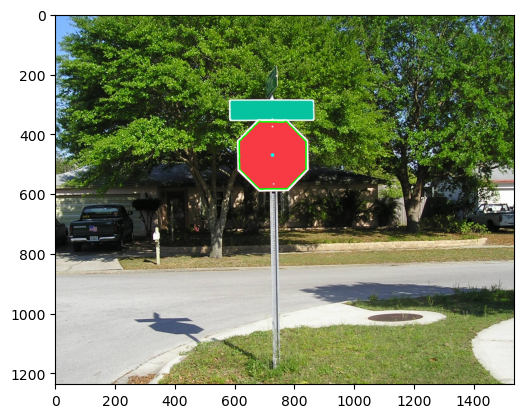

In [76]:
center = get_contour_center(largest_contour)

# Draw a circle at the contour center
draw_circle(image_copy, center)
plt.imshow(image_copy);

<a id="ContourArea"></a>
## 7. Contour Area

Contour area is also helpful for calculating how far an object is from the camera, since the closer an object is, the more pixels it will take up on the screen.

## Exercise 8

In this section, we will measure the area of the stop sign. 

Using previous examples from this notebook, **print the largest contour's area and display the image with the contour (again).**

41346.0


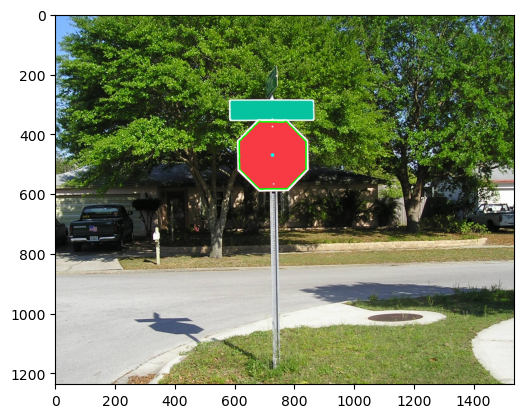

In [78]:
# TODO: Calculate and print the largest contour's area
if largest_contour is not None:
    print(cv2.contourArea(largest_contour))


# TODO: Display the image with the contour drawn on top (again)
plt.imshow(image_copy)
